Best Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

In [6]:
# Load rolling window sequences (shape: [num_samples, window_size, num_features])
X = np.load("/content/drive/MyDrive/prognosAI-Infosys-intern-project/milestone_2/week_3/Day_10/rolling_window_sequences.npy")      # Feature array
# Load metadata that contains engine_id, cycle, RUL, etc.
metadata = pd.read_csv("/content/drive/MyDrive/prognosAI-Infosys-intern-project/milestone_2/week_3/Day_11/sequence_metadata_with_RUL.csv")
y = metadata["RUL"].values                     # Target RUL array

# Print shapes to verify
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (152559, 30, 66)
y shape: (152559,)


In [7]:
# Split into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)

# Inspect sample batches
print("Sample X_train[0] batch shape:", X_train[0].shape)
print("First 5 RUL targets:", y_train[:5])

Train shape: (122047, 30, 66) (122047,)
Val shape: (30512, 30, 66) (30512,)
Sample X_train[0] batch shape: (30, 66)
First 5 RUL targets: [ 56. 296.  86. 122. 121.]


In [8]:
# Data Pipeline / Generator (optional, for very large data)
# Keras can accept Numpy arrays directly in fit(), so for most practical cases, we can skip writing a custom generator
# If memory is a concern, use tf.data.Dataset.from_tensor_slices
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(1)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(1)

In [9]:
# Model with 2 stacked LSTM layers, dropout and L2 weight regularization
def build_stacked_lstm_model(input_shape, lstm_units=64, dropout_rate=0.3, l2_reg=1e-4):
    model = Sequential([
        LSTM(lstm_units, activation='tanh', return_sequences=True,
             kernel_regularizer=regularizers.l2(l2_reg),
             input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(lstm_units, activation='tanh', return_sequences=False,
             kernel_regularizer=regularizers.l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(1)
    ])
    return model

model_stacked = build_stacked_lstm_model(input_shape=(X.shape[1], X.shape[2]))
model_stacked.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_stacked.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        33,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,625 (260.25 KB)

 Trainable params: 66,625 (260.25 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Traning Setup: Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1
)
model_ckpt = ModelCheckpoint('/content/drive/MyDrive/prognosAI-Infosys-intern-project/milestone_2/week_4/Day_16/best_model.keras', monitor='val_loss', verbose=1
)

In [13]:
# Model Training
history = model_stacked.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr, model_ckpt]
)

Epoch 1/50
1903/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6543.0322
Epoch 1: saving model to /content/drive/MyDrive/prognosAI-Infosys-intern-project/milestone_2/week_4/Day_16/best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - loss: 6539.9463 - val_loss: 3960.6885 - learning_rate: 0.0010
Epoch 2/50
1904/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3955.0627
Epoch 2: saving model to /content/drive/MyDrive/prognosAI-Infosys-intern-project/milestone_2/week_4/Day_16/best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - loss: 3954.7275 - val_loss: 3224.6655 - learning_rate: 0.0010
Epoch 3/50
1904/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3439.6516
Epoch 3: saving model to /content/drive/MyDrive/prognosAI-Infosys-intern-project/milestone_2/week_4/Day_16/best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 3439.3911 - val_loss: 2802.0222 - learning_rate: 0.0010
Epoch 4/50
1903/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3016.0330
Epoch 4: savin

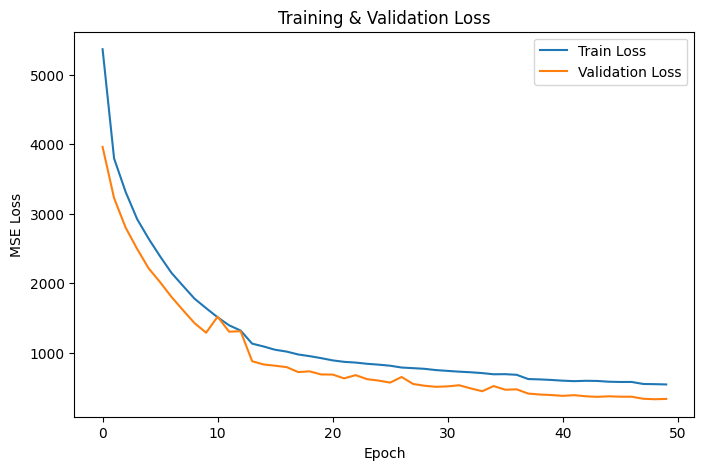

In [14]:
# Training and Validation Curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


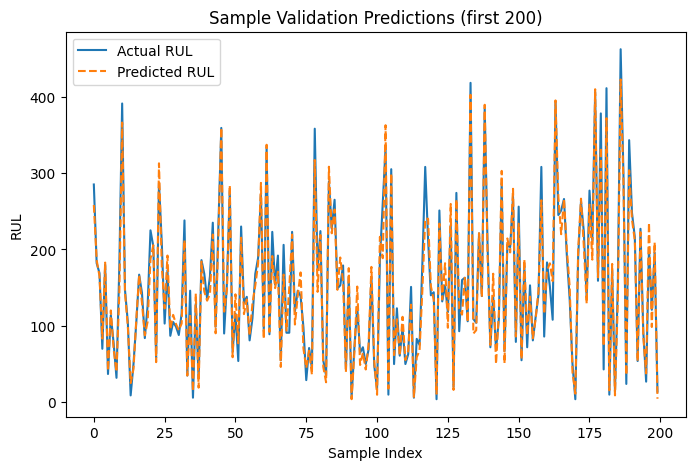

In [15]:
# Verify Model Predictions
val_pred = model_stacked.predict(X_val[:200]).flatten()
plt.figure(figsize=(8,5))
plt.plot(y_val[:200], label='Actual RUL')
plt.plot(val_pred, label='Predicted RUL', linestyle='--')
plt.title('Sample Validation Predictions (first 200)')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.show()

Observations:

1. Prevents overfitting by penalizing large weights.

2. Learns temporal patterns effectively through stacked LSTM layers.

3. Stable and robust training with dropout + L2 combo.

4. Suitable for real-time prediction (uses only past data).

5. Simpler and faster than attention-based models.

6. Generalizes well across different engines or machines.

7. Best trade-off between accuracy, complexity, and deployability.